In [1]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from collections import Counter
from pprint import pprint
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.patches as mpatches
import spacy
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8.0, 4.0)


In [2]:
nlp = spacy.load('en')

In [3]:
# Code adapted from http://stackoverflow.com/a/28384887/584121
class DenseTransformer(TransformerMixin):
    
    def __init__(self, *args, **kwargs): 
        return

    def get_params(self, deep=True): 
        """ Dummy method. """
        return {'None': 'None'}
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [30]:
class Text(BaseEstimator, TransformerMixin): 
    def __init__(self, lenMin=2000, lenMax=2000000, maxChars=8):
        self.charDict = {}
        self.lenMin = lenMin
        self.lenMax = lenMax
        self.maxChars = maxChars
        
    def fit(self, *_):
        return self

    def transform(self, filename): 
        self.tree = etree.parse(filename)
        # First find and remove all letters-within-letters. 
        self.nestedLetters = self.tree.findall('.//floatingText[@type="letter"]')
        for letter in self.nestedLetters: 
            self.parseLetter(letter)
            letter.getparent().remove(letter)
        
        # Parse letters
        self.allLetters = self.tree.findall('.//div[@type="letter"]')
        for letter in self.allLetters: 
            self.parseLetter(letter)
            
        # Flatten charDict
        self.allDocs = []
        self.allLabels = []
        for char in self.charDict: 
            for letter in self.charDict[char]: 
                self.allDocs.append(letter)
                self.allLabels.append(char)
        
        #Restrict to only the ones with appropriate lengths
        self.docs = []
        self.labels = []
        self.topChars = dict(Counter(self.allLabels).most_common(self.maxChars))
        for doc, label in zip(self.allDocs, self.allLabels): 
            if len(doc) > self.lenMin and len(doc) < self.lenMax:
                if label in self.topChars: 
                    self.docs.append(doc)
                    self.labels.append(label)    
    
        self.chars = list(set(self.labels))
        
        self.numericLabels = [self.chars.index(char) for char in self.labels]
        
        self.lengths = [len(doc) for doc in self.docs]
        
        self.docs = [self.cleanLetter(doc) for doc in self.docs]
        
        return self.docs
        
    def plotLettersPerChar(self): 
        lettersPerChar = dict(Counter(self.labels).most_common(20))
        pd.Series(lettersPerChar).plot(kind='bar')
    
    def plotHist(self): 
        print('%s documents' % len(self.docs))
        pd.Series(self.lengths).hist()
        
    def parseLetter(self, letter):
#         print(letter.tag, letter.sourceline)
        if 'who' in letter.attrib: 
            attribution = letter.attrib['who']
#             print('attribution: ', attribution)
        elif len(letter.findall('.//signed[@who]'))>0:  
            signed = letter.findall('.//signed[@who]')
#             print('signed: ', signed)
            if len(signed) > 0: 
                attribution = signed[0].attrib['who']
#                 print('signed: ', attribution)
        else: 
            attribution = None
        if attribution is not None: 
            ps = letter.findall('.//p')
            text = "".join(["".join(p.itertext()) for p in ps])
#             print(text[:100])
            if attribution in self.charDict: 
                self.charDict[attribution].append(text)
            else: 
                self.charDict[attribution] = [text]
    
    def cleanLetter(self, letter): 
        return re.sub('ſ', 's', letter)
                
        

In [5]:
def translateNumColors(colorList): 
    colorDict = 'rgbcymkw'
    return [colorDict[numColor] for numColor in colorList]    

def translateNumColor(color): 
    colorDict = 'rgbcmyk'
    return colorDict[color]

In [6]:
def verboseGridSearch(pipeline, parameters, docs, labels): 
    scorer = metrics.make_scorer(metrics.adjusted_rand_score)    
    grid_search = GridSearchCV(pipeline, parameters, scoring=scorer, n_jobs=-1, verbose=1)

    print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     pprint(parameters)
    t0 = time()
    grid_search.fit(docs, labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search

In [7]:
def plotLabeled(transformed, labels, wordLabels, lengths): 
    plt.scatter(transformed[:,0], transformed[:,1], 
                c=translateNumColors(labels), s=lengths)

    # Build legend
    colorLabelAssociations = list(set(list(zip(labels, wordLabels, translateNumColors(labels)))))
#     print(colorLabelAssociations)
    legends = [mpatches.Patch(color=assoc[2], label=assoc[1])
              for assoc in colorLabelAssociations]
    plt.legend(handles=legends, loc='lower right', fontsize='small')

In [8]:
transformPipeline = Pipeline([    
                         ('tfidf', TfidfVectorizer(max_df=0.3,
                                                  max_features=500)),
                         ('todense', DenseTransformer()),
                         ('pca', PCA(n_components=5)),
#                          ('gmm', GaussianMixture(n_components=6)),
                        ])

173 documents


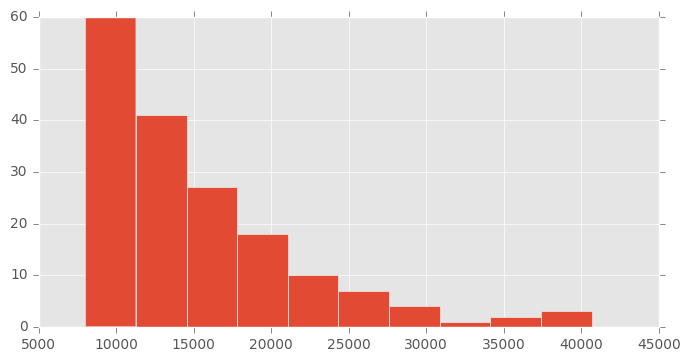

In [42]:
text = Text(lenMin=8000, lenMax=50000, maxChars=4).fit()
docs = text.transform('clarissa.xml')
labels = text.numericLabels
wordLabels = text.labels
lengths = [length/500 for length in text.lengths]
text.plotHist()
# text.plotLettersPerChar()

In [43]:
transformed = transformPipeline.fit_transform(docs)
transformed.shape

(173, 5)

In [44]:
parsedDocs = [nlp(doc) for doc in docs]

In [45]:
vecs = np.array([doc.vector for doc in parsedDocs])
vecs.shape

(173, 300)

In [62]:
pca = PCA(n_components=5)
transformed = pca.fit_transform(vecs)
transformed.shape
# transformed = vecs

(173, 5)

In [65]:
def gmmIterate(): 
    gmm = GaussianMixture(n_components=4).fit(transformed)
    bgm = BayesianGaussianMixture(n_components=4).fit(transformed)
    assignments = gmm.predict(transformed)
    ars = metrics.adjusted_rand_score(assignments, labels) 
    print(ars)
    return assignments, ars

In [66]:
arsHistory = []
for i in range(20): 
    assignments, ars = gmmIterate()
    arsHistory.append(ars)
pd.Series(arsHistory).describe()

0.199158871808
0.191231651918
0.176854259715
0.199460593499
0.152892888503
0.228786828575


/usr/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0.199487889579
0.137138031342
0.206086591816
0.20599716711
0.2209044352
0.199460593499
0.199158871808
0.19899089979
0.197553267439
0.21151241832
0.193563264921
0.199460593499
0.174723262374
0.149231383694


count    20.000000
mean      0.192083
std       0.023247
min       0.137138
25%       0.187637
50%       0.199159
75%       0.201115
max       0.228787
dtype: float64

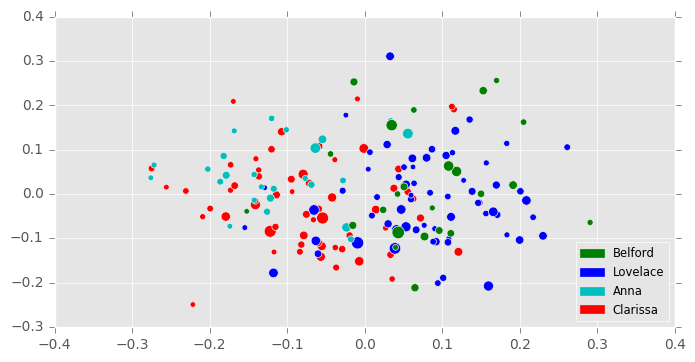

In [67]:
plotLabeled(transformed, labels, wordLabels, lengths)

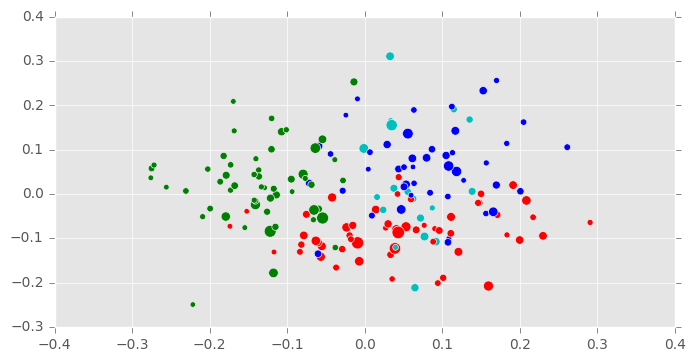

In [68]:
plt.scatter(transformed[:,0], transformed[:,1], 
            c=translateNumColors(assignments), s=lengths)

# By POS

In [217]:
def POSRepresentation(doc): 
    return dict(Counter([w.tag for w in doc]).most_common(20))

In [218]:
POSes = [POSRepresentation(doc) for doc in parsedDocs]

In [219]:
series = [pd.Series(pos) for pos in POSes]
bigTable = pd.concat(series, axis=1, join='outer')

In [220]:
bigTable = bigTable.T
bigTable.shape

(179, 26)

In [221]:
bigTable = bigTable.fillna(0)

In [222]:
bigTable.shape

(179, 26)

In [223]:
gmm = GaussianMixture(n_components=4).fit(bigTable)
# bgm = BayesianGaussianMixture(n_components=4).fit(bigTable)
assignments = gmm.predict(bigTable)

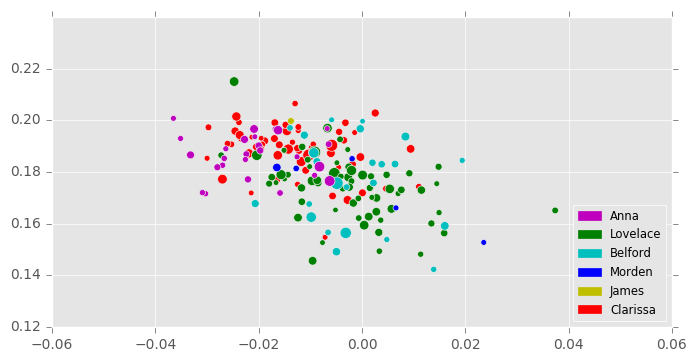

In [224]:
plotLabeled(transformed, labels, wordLabels, lengths)

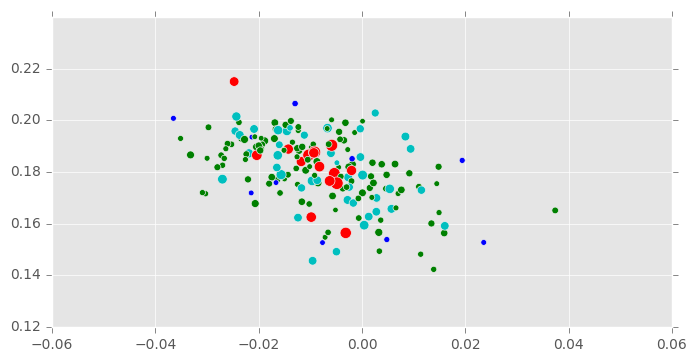

In [225]:
plt.scatter(transformed[:,0], transformed[:,1], 
            c=translateNumColors(assignments), s=lengths)

In [226]:
metrics.adjusted_rand_score(assignments, labels)

0.0049435362365704881

In [227]:
metrics.adjusted_mutual_info_score(assignments, labels)

0.0028047577713810373

# By verbs

In [302]:
roots = [pd.Series(dict(Counter([sent.root.lemma for sent in doc.sents]))) for doc in parsedDocs]

In [304]:
df = pd.concat(roots, axis=1, join='outer')

In [306]:
df = df.fillna(0)

In [308]:
df = df.T
df.shape

(179, 2250)

In [319]:
pca = PCA(n_components=100)
pcaOut = pca.fit_transform(df)

In [320]:
pcaOut.shape

(179, 100)

In [321]:
gmm = GaussianMixture(n_components=4).fit(pcaOut)
# bgm = BayesianGaussianMixture(n_components=4).fit(bigTable)
assignments = gmm.predict(pcaOut)

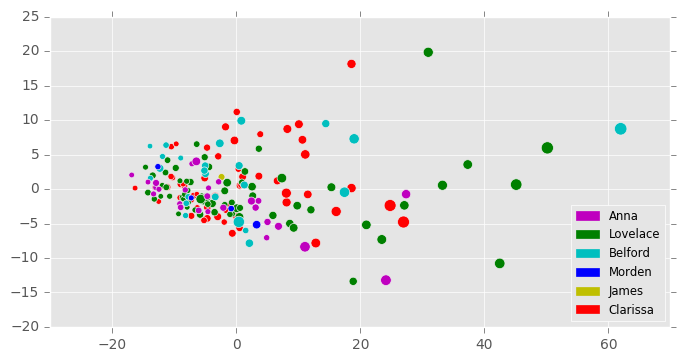

In [322]:
plotLabeled(pcaOut, labels, wordLabels, lengths)

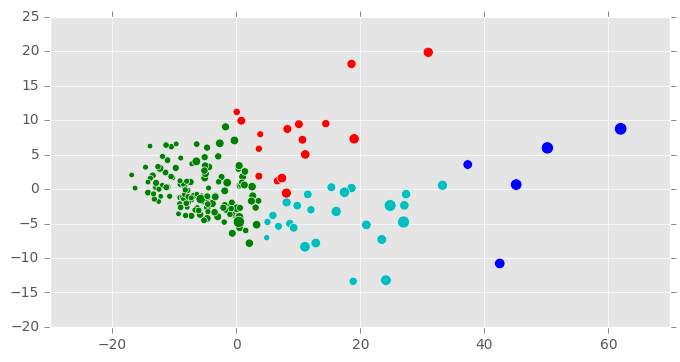

In [324]:
plt.scatter(pcaOut[:,0], pcaOut[:,1], 
            c=translateNumColors(assignments), s=lengths)

In [325]:
metrics.adjusted_rand_score(assignments, labels)

-0.02128852586054961

In [326]:
metrics.adjusted_mutual_info_score(assignments, labels)

0.020904590069947042